# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network architecure which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we running a GPU?
! nvidia-smi

Wed Sep 27 20:38:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-09-27 20:38:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 142.250.107.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   198MB/s    in 0.8s    

2023-09-27 20:38:57 (198 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder=target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)

  # Read in the image and plot it using matplotlib
  img=mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


array([[[ 39,  41,  54],
        [ 29,  31,  44],
        [ 31,  33,  45],
        ...,
        [109,  70,  37],
        [104,  65,  32],
        [111,  72,  39]],

       [[ 40,  42,  55],
        [ 32,  34,  47],
        [ 34,  36,  48],
        ...,
        [113,  74,  41],
        [111,  72,  39],
        [118,  79,  46]],

       [[ 38,  40,  52],
        [ 32,  34,  46],
        [ 34,  36,  48],
        ...,
        [109,  73,  39],
        [108,  72,  38],
        [114,  78,  44]],

       ...,

       [[ 23,  34,  28],
        [ 20,  31,  25],
        [ 19,  30,  24],
        ...,
        [225, 211, 174],
        [222, 207, 176],
        [210, 195, 166]],

       [[ 18,  30,  26],
        [ 20,  32,  28],
        [ 23,  34,  30],
        ...,
        [223, 208, 169],
        [222, 206, 173],
        [207, 190, 160]],

       [[ 26,  38,  34],
        [ 25,  37,  33],
        [ 23,  34,  30],
        ...,
        [223, 208, 169],
        [221, 205, 172],
        [205, 188, 158]]

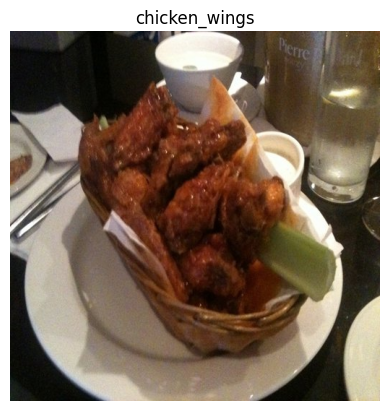

In [ ]:
view_random_image("10_food_classes_10_percent/train","chicken_wings")

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models [here](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model [link](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)

In [ ]:
# Let's compare the following two models
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
# Import dependancies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) #freeze the already learned model

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


## Creating and testing ResNet TensorFlow Hub Feature Extractiion model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                             experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/20230927-203909
Epoch 1/5
24/24 [==============================] - 25s 532ms/step - loss: 1.9383 - accuracy: 0.3587 - val_loss: 1.2144 - val_accuracy: 0.6184
Epoch 2/5
24/24 [==============================] - 13s 552ms/step - loss: 0.9081 - accuracy: 0.7267 - val_loss: 0.8951 - val_accuracy: 0.7052
Epoch 3/5
24/24 [==============================] - 13s 544ms/step - loss: 0.6473 - accuracy: 0.8053 - val_loss: 0.7637 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 11s 455ms/step - loss: 0.4787 - accuracy: 0.8747 - val_loss: 0.7077 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 13s 576ms/step - loss: 0.3838 - accuracy: 0.9173 - val_loss: 0.6754 - val_accuracy: 0.7820


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% of training examples

In [ ]:
# Let's create a function for our loss curves...
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object

  Return:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

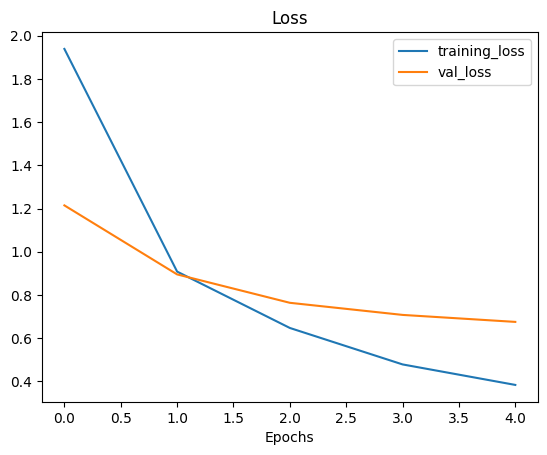

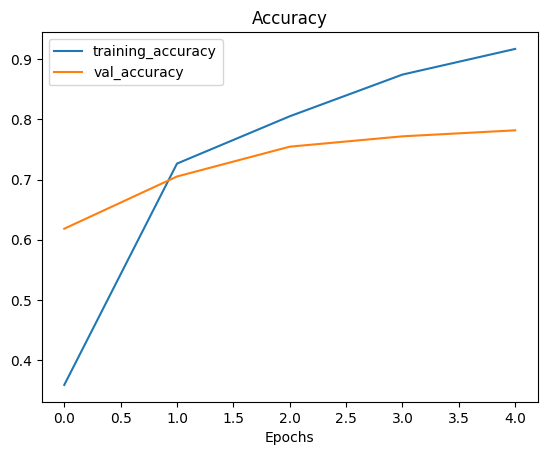

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficient_model = create_model(efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficient_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                             experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/20230927-204101
Epoch 1/5
24/24 [==============================] - 26s 618ms/step - loss: 1.8878 - accuracy: 0.4120 - val_loss: 1.3201 - val_accuracy: 0.7112
Epoch 2/5
24/24 [==============================] - 10s 435ms/step - loss: 1.0938 - accuracy: 0.7507 - val_loss: 0.8845 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 12s 497ms/step - loss: 0.7773 - accuracy: 0.8267 - val_loss: 0.7079 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 13s 546ms/step - loss: 0.6186 - accuracy: 0.8653 - val_loss: 0.6219 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 10s 444ms/step - loss: 0.5245 - accuracy: 0.8867 - val_loss: 0.5646 - val_accuracy: 0.8648


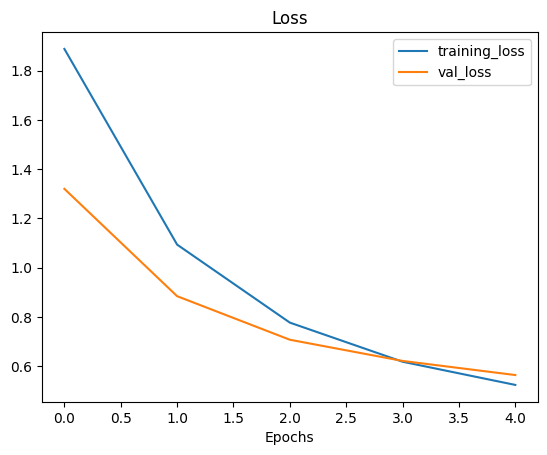

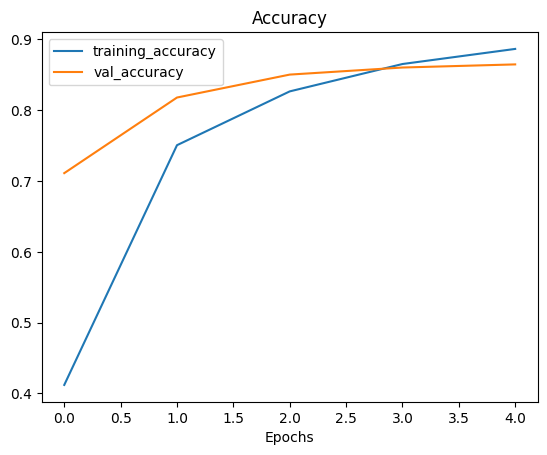

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing with no changes what so over (e.g. using ImageNet model on 1000 ImageNet classes, none of your own.
* **"Feature extraction" transfer learning**- use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑**Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
 --one_shot

2023-09-27 21:13:36.818287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   SFXB-HFBV



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/k3YbKibQT26OZrEVP2KpJA/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list


2023-09-27 21:21:22.689488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/k3YbKibQT26OZrEVP2KpJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   k3YbKibQT26OZrEVP2KpJA
	Created              2023-09-27 21:15:43 (5 minutes ago)
	Updated              2023-09-27 21:15:45 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6310046
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id k3YbKibQT26OZrEVP2KpJA

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2023-09-27 21:24:37.272167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/k3YbKibQT26OZrEVP2KpJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   k3YbKibQT26OZrEVP2KpJA
	Created              2023-09-27 21:15:43 (8 minutes ago)
	Updated              2023-09-27 21:15:45 (8 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6310046
Total: 1 experiment(s)
